In [1]:
import os
from dotenv import load_dotenv
import psycopg2
from psycopg2.extras import DictCursor
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

/Users/chuckschultz/.local/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Function that connects to database
load_dotenv()
def db_connect():
    db_name = os.environ['db_name']
    db_user = os.environ['db_user']
    db_host = os.environ['db_host']
    db_credentials = os.environ['db_creds']
  
    conn_string = "dbname='" + str(db_name) + "' user='" + str(db_user) + "' host='" + str(db_host) + "' password='" + str(db_credentials) + "'"

    try:
        conn = psycopg2.connect(str(conn_string))
        conn.autocommit = True
    except:
        print("Unable to connect to the database")

    cur = conn.cursor(cursor_factory=DictCursor)
    return cur

cur = db_connect()

In [3]:
def bar_plot(data_column, x_label, y_label, title, size=(12,8), rotate=0):
    a = data_column.value_counts()
    codes = a.index
    count = a.values
    plt.figure(figsize=size)
    ax = sns.barplot(x=codes, y=count)
    ax.set_xlabel(x_label, fontsize=15)
    ax.set_ylabel(y_label, fontsize=15)
    ax.set_title(title, fontsize=22)
    plt.xticks(rotation=rotate)
    plt.show()

In [4]:
def bar_plot_region(region, x_label, y_label, title, size=(12,8), rotate=0):
    region_df = disaster_df_full[disaster_df_full.region == region]
    a = region_df.disaster_type.value_counts()
    codes = a.index
    count = a.values
    plt.figure(figsize=size)
    ax = sns.barplot(x=codes, y=count)
    ax.set_xlabel(x_label, fontsize=15)
    ax.set_ylabel(y_label, fontsize=15)
    ax.set_title(title, fontsize=22)
    plt.xticks(rotation=rotate)
    plt.show()

In [5]:
def box_plot(data, x_label, y_label, title, size=(12,8)):
    plt.figure(figsize=size)
    ax = sns.boxplot(x=data)
    ax.ticklabel_format(style='plain', axis='x', useMathText=True)
    ax.set_xlabel(x_label, fontsize=15)
    ax.set_ylabel(y_label, fontsize=15)
    ax.set_title(title, fontsize=22)
    plt.show()

In [6]:
def reg_plot(region, x_label, y_label, title, size=(12,8)):
    region_df = disaster_df_full[disaster_df_full.region == region]
    year_vc = region_df['year'].value_counts().sort_index()
    X = year_vc.index
    Y = year_vc.values
    
    plt.figure(figsize=size)
    ax = sns.regplot(x=X, y=Y, ci=None, data=disaster_df_full, line_kws={"color": "black"})
    ax.ticklabel_format(style='plain', axis='both', useOffset=False, useMathText=True)
    ax.set_xlabel(x_label, fontsize=15)
    ax.set_ylabel(y_label, fontsize=15)
    ax.set_title(title, fontsize=22)
    plt.show()

In [7]:
query = "SELECT (extract(year from date))::int as year, AVG(tmin), AVG(tmax), AVG(tavg), AVG(prcp), AVG(snow), AVG(snwd) FROM weather.weather_clean WHERE extract(year from date) < 2021 GROUP BY year ORDER BY year"
cur.execute(query)
results = cur.fetchall()

weather_df = pd.DataFrame(results, columns=['year','tmin','tmax','tavg','prcp','snow','snwd'])
weather_df

,year,tmin,tmax,tavg,prcp,snow,snwd
0,1990,46.751136,63.276276,55.013706,0.120957,0.080108,4.917624
1,1991,46.165117,62.568618,54.366868,0.116913,0.069574,5.092871
2,1992,46.240191,62.899981,54.570086,0.117116,0.069587,4.900861
3,1993,47.222572,63.669614,55.446093,0.117592,0.056154,4.489111
4,1994,48.316513,65.238231,56.777372,0.124054,0.068569,3.356423
5,1995,47.383787,64.239496,55.811641,0.123440,0.063278,2.892808
6,1996,47.804272,64.658503,56.231388,0.133255,0.075748,3.470398
7,1997,47.853521,64.507270,56.180395,0.117464,0.073669,3.584055
8,1998,48.414172,64.894335,56.654253,0.116503,0.059583,3.388906
9,1999,47.872045,64.471927,56.171986,0.132776,0.087518,3.451413


In [8]:
# Load disaster data to DataFrame
query = "SELECT year, COUNT(*), (SUM(deaths))::int, (SUM(damages))::int FROM weather.disasters_clean WHERE year >= 1990 and year < 2021 GROUP BY year ORDER BY year"
cur.execute(query)
results = cur.fetchall()

disaster_df = pd.DataFrame(results, columns=['year','count','deaths','damages'])
disaster_df

,year,count,deaths,damages
0,1990,303,53133,49779822
1,1991,266,189707,37593461
2,1992,234,18913,55098163
3,1993,267,21821,50992889
4,1994,255,15590,71033574
5,1995,278,637166,155071039
6,1996,273,31595,43327243
7,1997,323,30024,40261946
8,1998,365,62673,84132740
9,1999,416,76906,112248954


In [9]:
query = "SELECT year, country_code, region, disaster_type, deaths, damages FROM weather.disasters_clean WHERE year >= 1990 and year < 2021 ORDER BY year"
cur.execute(query)
results = cur.fetchall()
disaster_df_full = pd.DataFrame(results, columns=['year','country_code','region','disaster_type','deaths','damages'])
disaster_df_full

,year,country_code,region,disaster_type,deaths,damages
0,1990,US,Northern America,Earthquake,NaN,NaN
1,1990,US,Northern America,Storm,79.0,NaN
2,1990,US,Northern America,Flood,3.0,45000.0
3,1990,RU,Russian Federation,Earthquake,NaN,NaN
4,1990,VN,South-Eastern Asia,Storm,15.0,NaN
...,...,...,...,...,...,...
11618,2020,CN,Eastern Asia,Flood,13.0,NaN
11619,2020,ID,South-Eastern Asia,Flood,NaN,NaN
11620,2020,PE,South America,Flood,NaN,NaN
11621,2020,US,Northern America,Storm,NaN,2900000.0


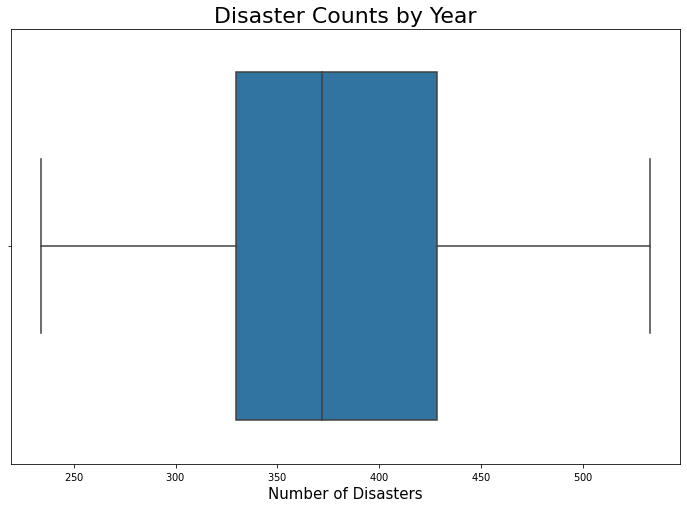

In [10]:
box_plot(disaster_df['count'], 'Number of Disasters', '', 'Disaster Counts by Year')

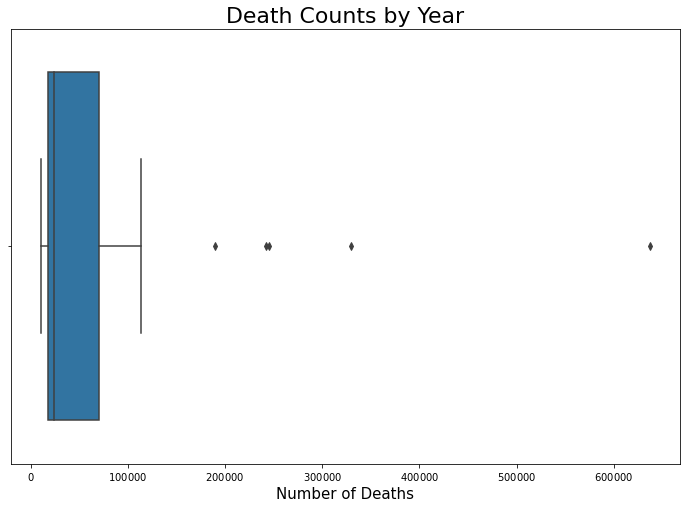

In [11]:
box_plot(disaster_df['deaths'], 'Number of Deaths', '', 'Death Counts by Year')

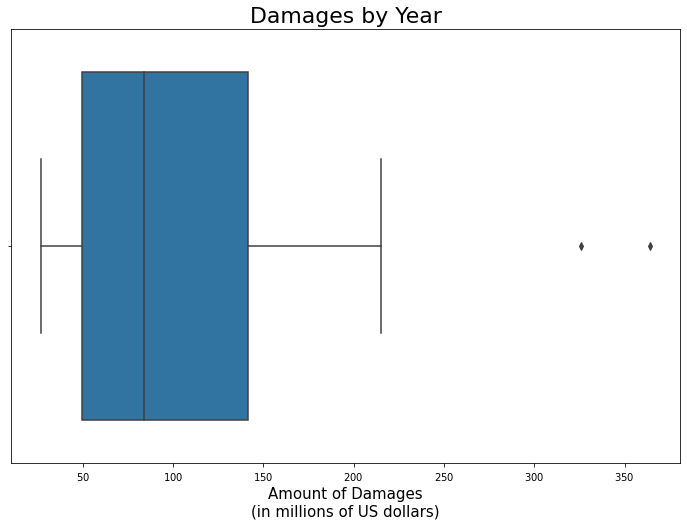

In [12]:
box_plot((disaster_df['damages']//1000000), 'Amount of Damages\n(in millions of US dollars)', '', 'Damages by Year')

In [13]:
print(disaster_df_full.region.unique())

['Northern America' 'Russian Federation' 'South-Eastern Asia'
 'Western Europe' 'Western Asia' 'Polynesia' 'Southern Africa'
 'Eastern Africa' 'Melanesia' 'South America' 'Middle Africa'
 'Western Africa' 'Southern Asia' 'Northern Europe' 'Southern Europe'
 'Australia and New Zealand' 'Eastern Asia' 'Northern Africa' 'Caribbean'
 'Central America' 'Central Asia' 'Eastern Europe' 'Micronesia']


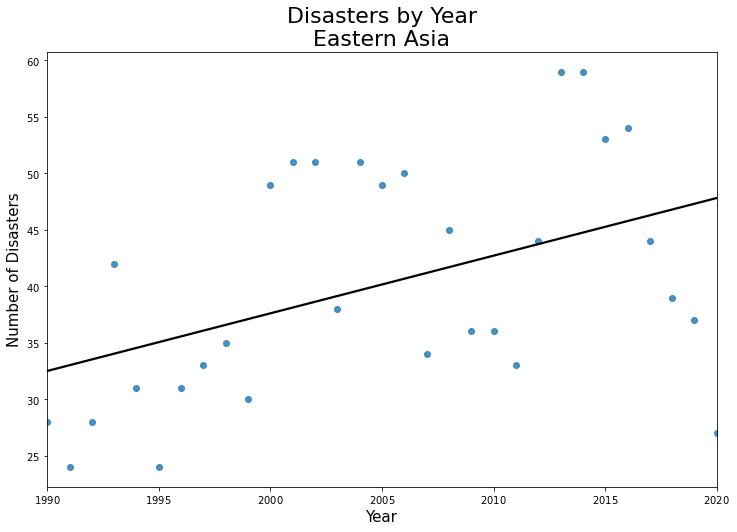

In [14]:
reg_plot('Eastern Asia', 'Year', 'Number of Disasters', 'Disasters by Year\nEastern Asia')

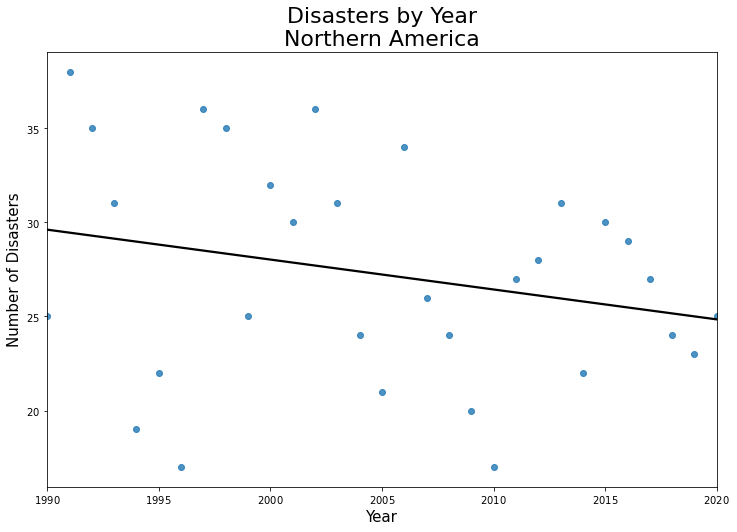

In [15]:
reg_plot('Northern America', 'Year', 'Number of Disasters', 'Disasters by Year\nNorthern America')

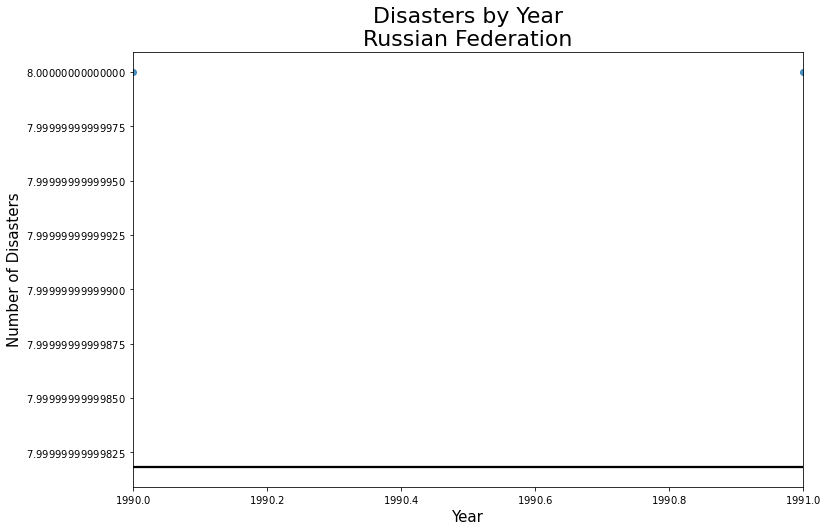

In [16]:
reg_plot('Russian Federation', 'Year', 'Number of Disasters', 'Disasters by Year\nRussian Federation')

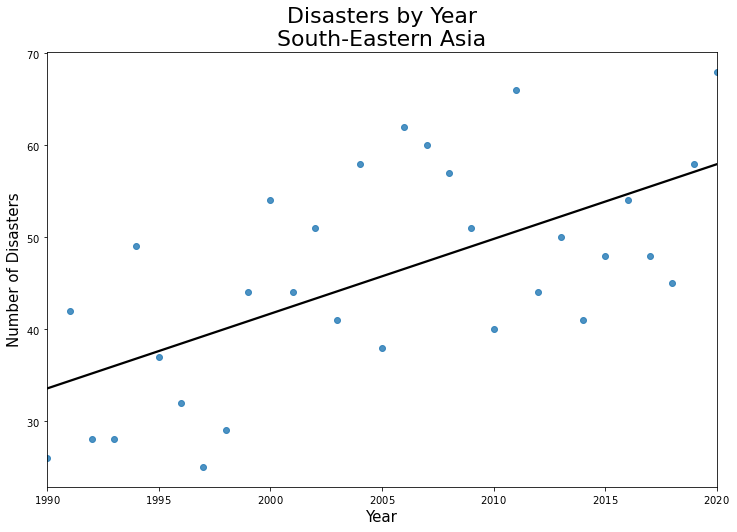

In [17]:
reg_plot('South-Eastern Asia', 'Year', 'Number of Disasters', 'Disasters by Year\nSouth-Eastern Asia')

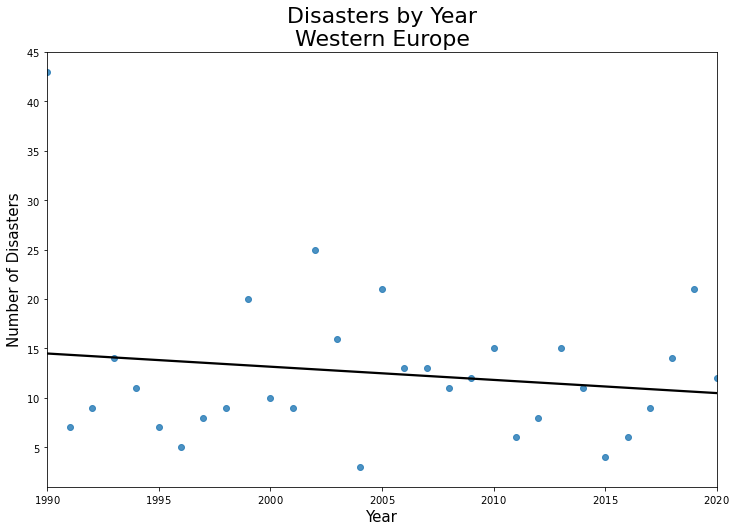

In [18]:
reg_plot('Western Europe', 'Year', 'Number of Disasters', 'Disasters by Year\nWestern Europe')

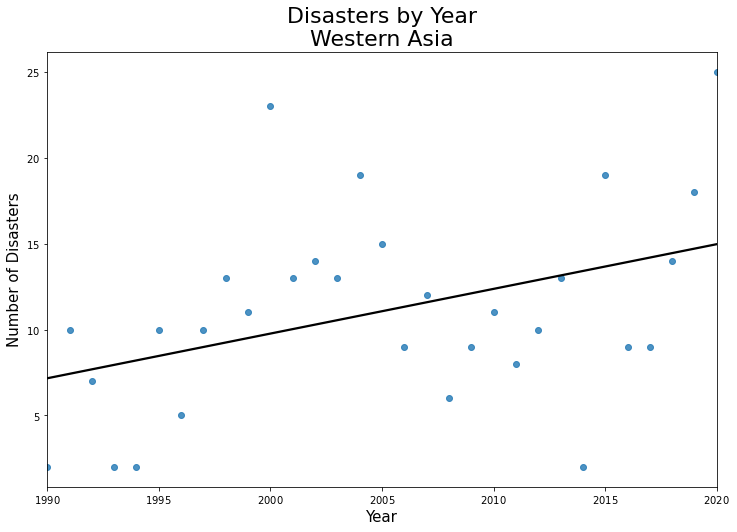

In [19]:
reg_plot('Western Asia', 'Year', 'Number of Disasters', 'Disasters by Year\nWestern Asia')

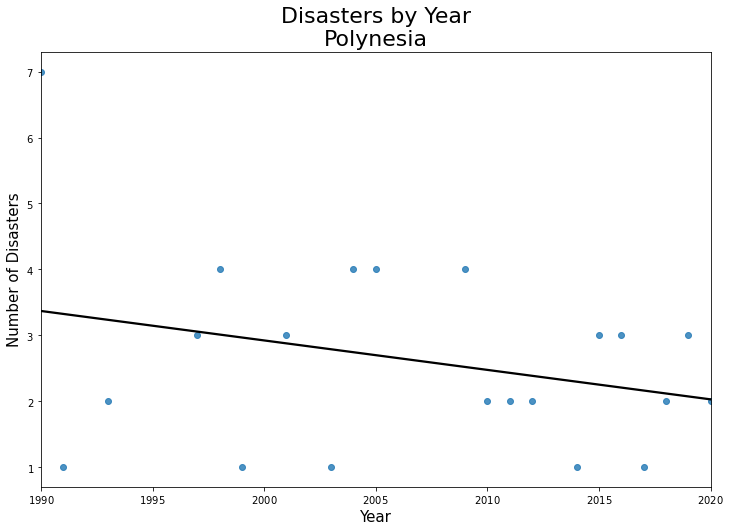

In [20]:
reg_plot('Polynesia', 'Year', 'Number of Disasters', 'Disasters by Year\nPolynesia')

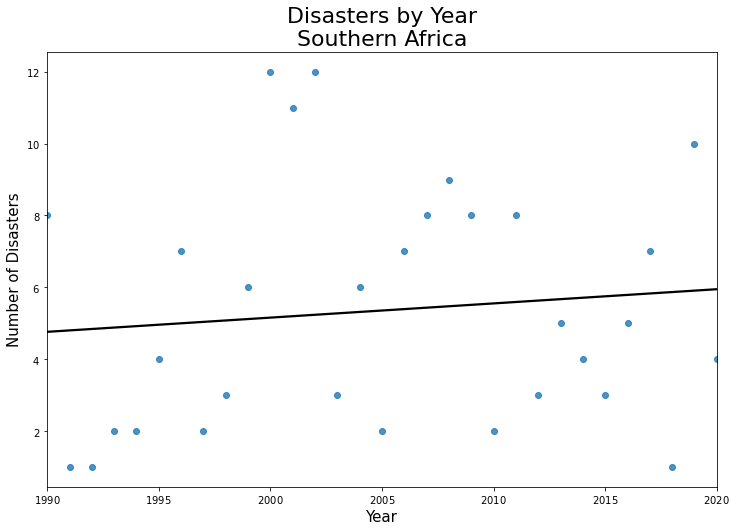

In [21]:
reg_plot('Southern Africa', 'Year', 'Number of Disasters', 'Disasters by Year\nSouthern Africa')

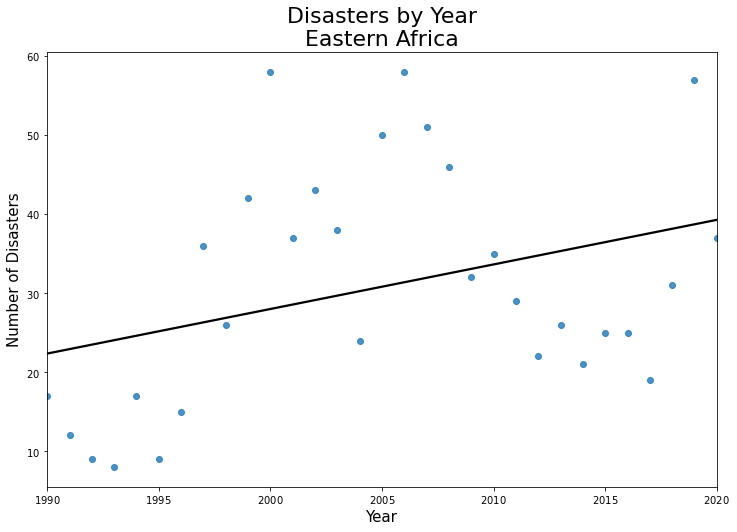

In [22]:
reg_plot('Eastern Africa', 'Year', 'Number of Disasters', 'Disasters by Year\nEastern Africa')

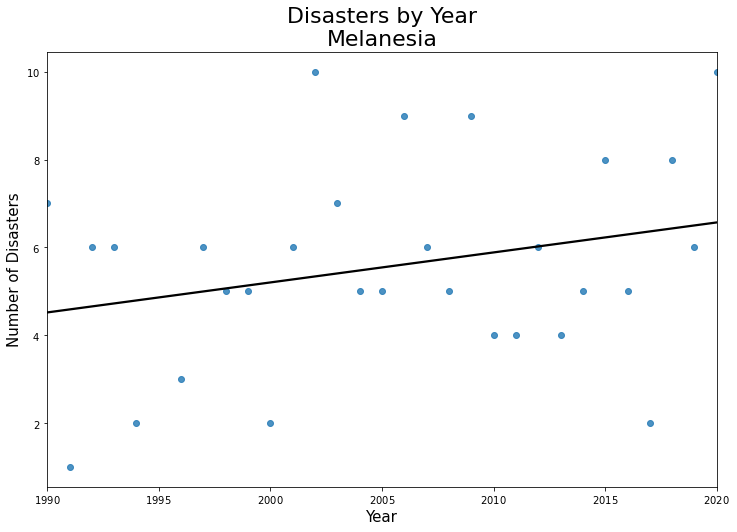

In [23]:
reg_plot('Melanesia', 'Year', 'Number of Disasters', 'Disasters by Year\nMelanesia')

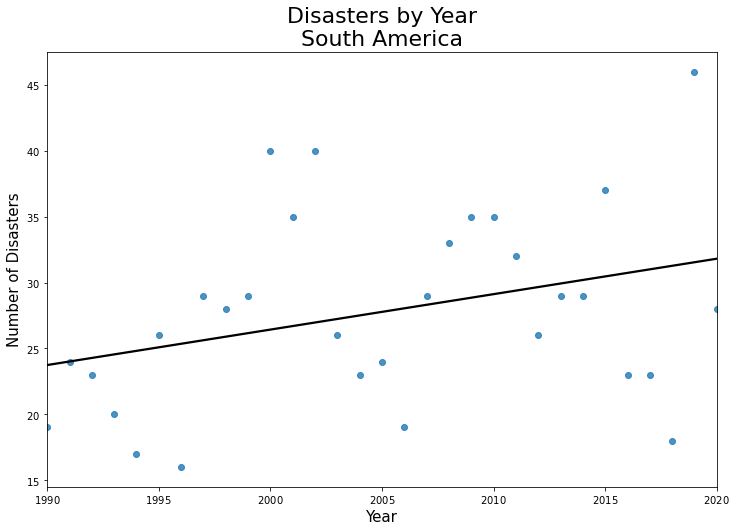

In [24]:
reg_plot('South America', 'Year', 'Number of Disasters', 'Disasters by Year\nSouth America')

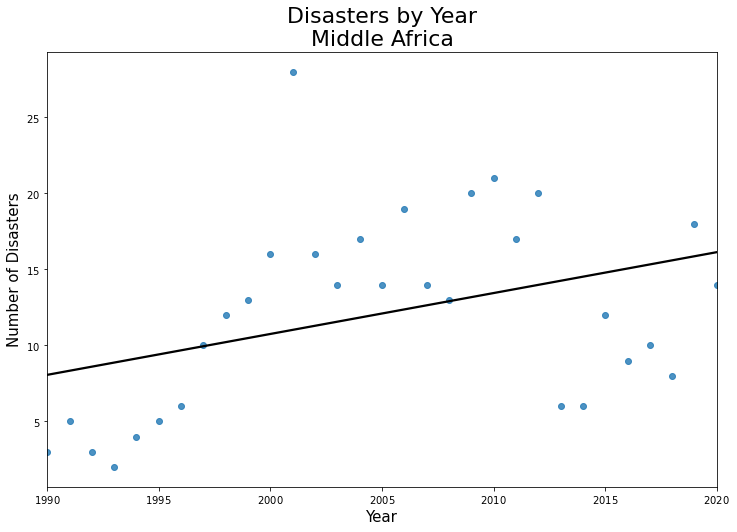

In [25]:
reg_plot('Middle Africa', 'Year', 'Number of Disasters', 'Disasters by Year\nMiddle Africa')

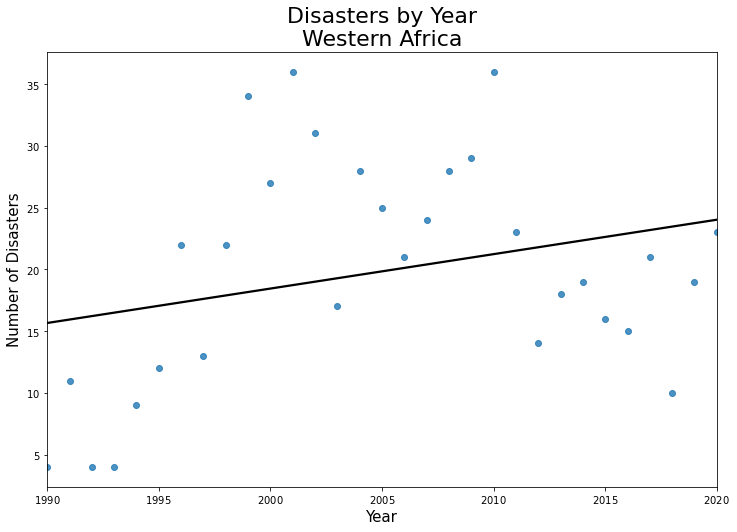

In [26]:
reg_plot('Western Africa', 'Year', 'Number of Disasters', 'Disasters by Year\nWestern Africa')

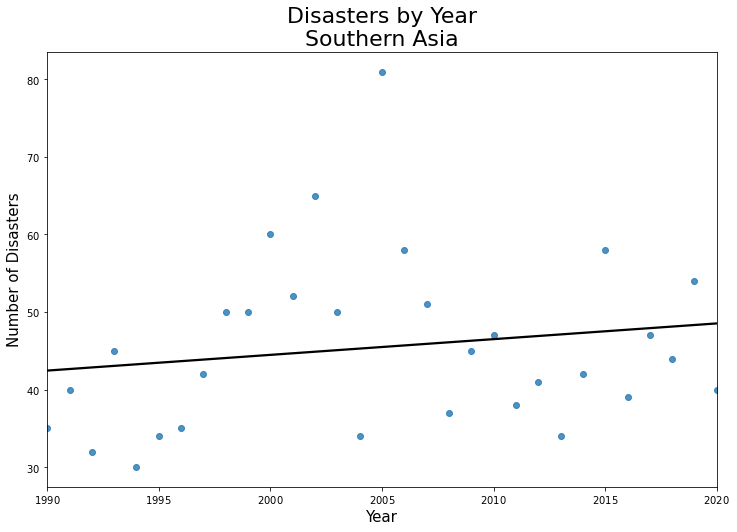

In [27]:
reg_plot('Southern Asia', 'Year', 'Number of Disasters', 'Disasters by Year\nSouthern Asia')

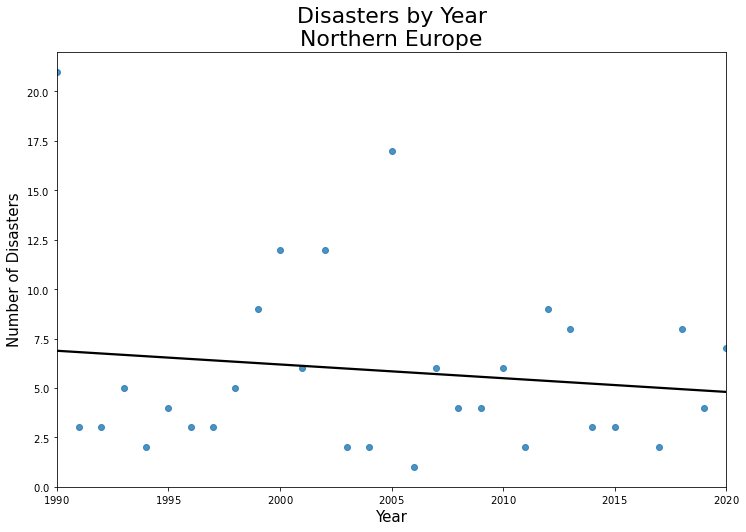

In [28]:
reg_plot('Northern Europe', 'Year', 'Number of Disasters', 'Disasters by Year\nNorthern Europe')

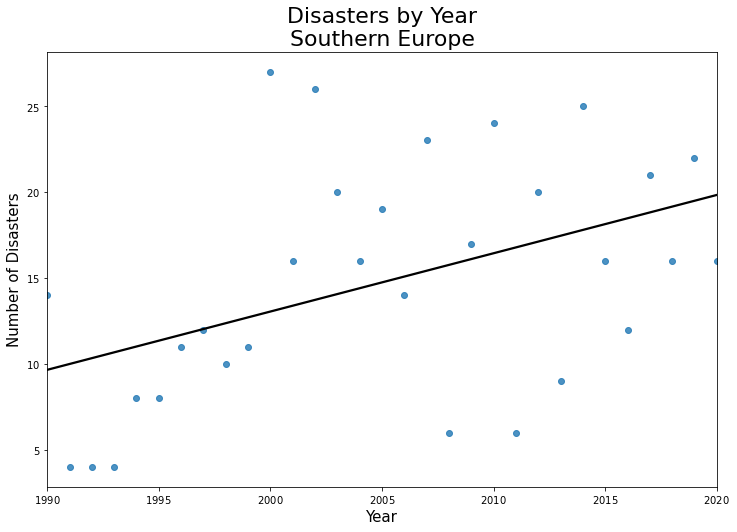

In [29]:
reg_plot('Southern Europe', 'Year', 'Number of Disasters', 'Disasters by Year\nSouthern Europe')

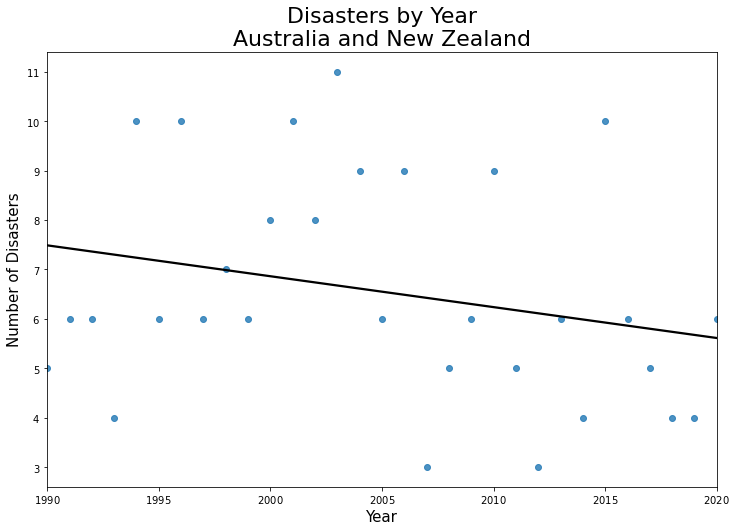

In [30]:
reg_plot('Australia and New Zealand', 'Year', 'Number of Disasters', 'Disasters by Year\nAustralia and New Zealand')

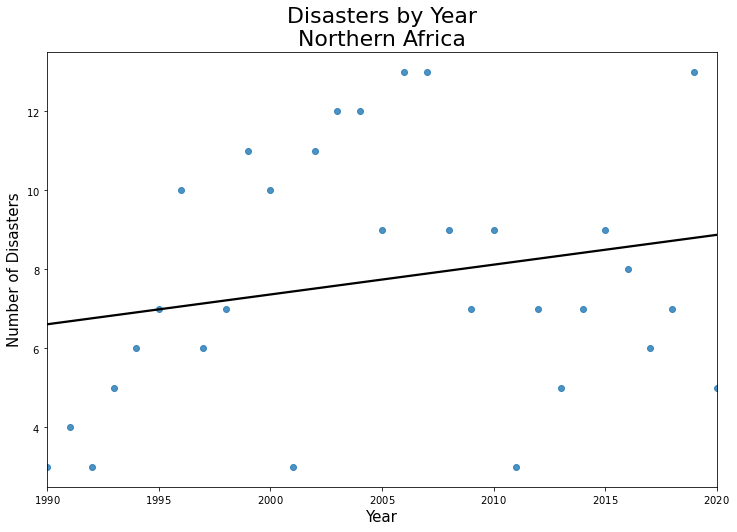

In [31]:
reg_plot('Northern Africa', 'Year', 'Number of Disasters', 'Disasters by Year\nNorthern Africa')

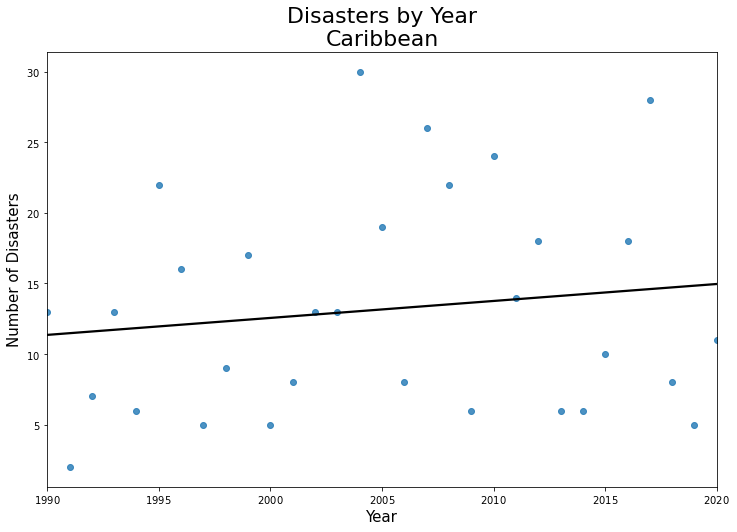

In [32]:
reg_plot('Caribbean', 'Year', 'Number of Disasters', 'Disasters by Year\nCaribbean')

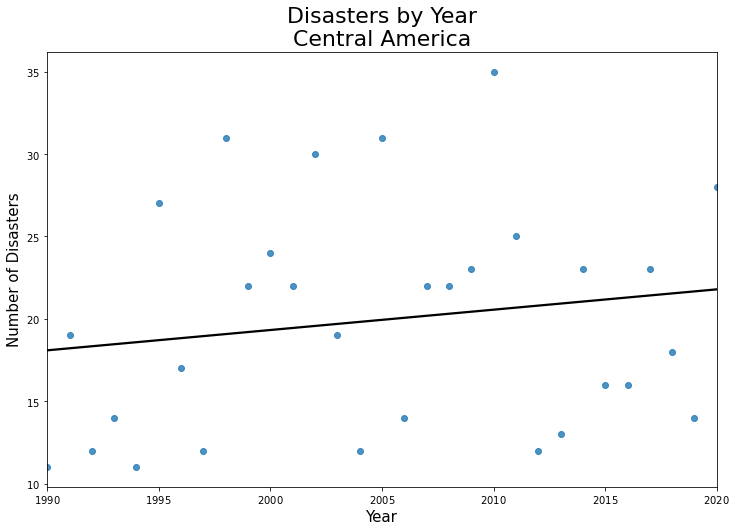

In [33]:
reg_plot('Central America', 'Year', 'Number of Disasters', 'Disasters by Year\nCentral America')

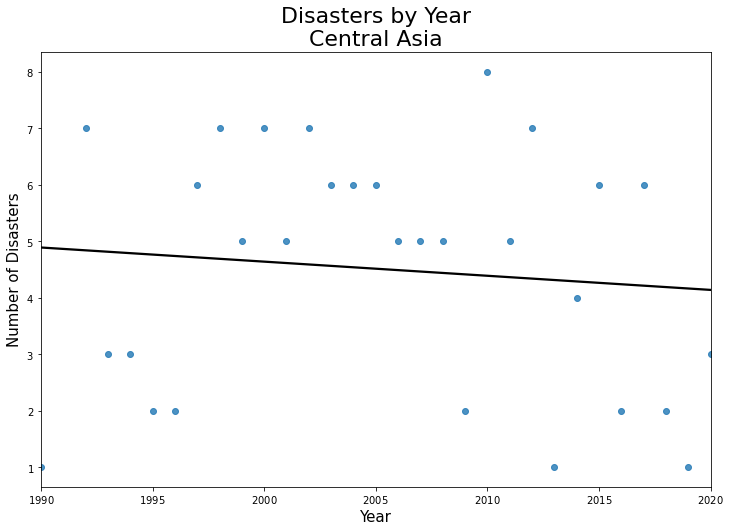

In [34]:
reg_plot('Central Asia', 'Year', 'Number of Disasters', 'Disasters by Year\nCentral Asia')

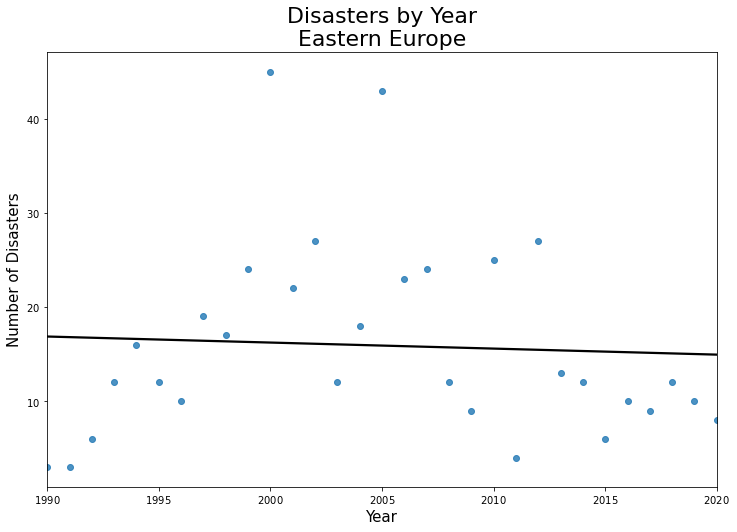

In [35]:
reg_plot('Eastern Europe', 'Year', 'Number of Disasters', 'Disasters by Year\nEastern Europe')

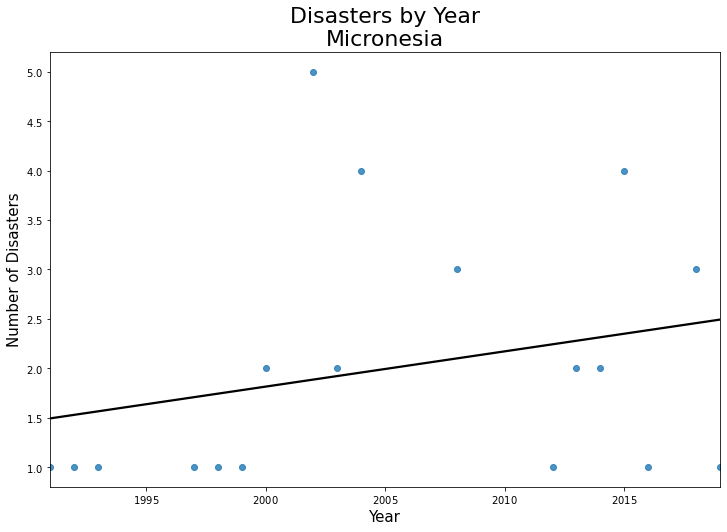

In [36]:
reg_plot('Micronesia', 'Year', 'Number of Disasters', 'Disasters by Year\nMicronesia')

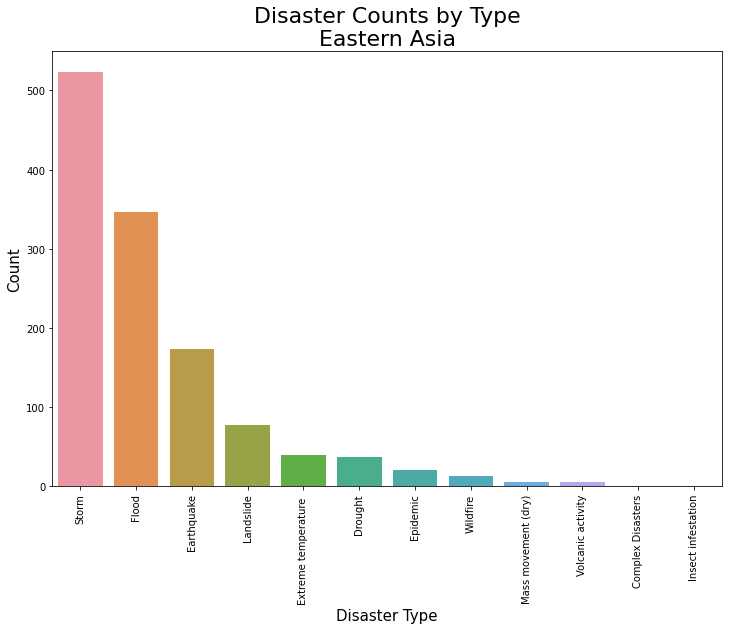

In [37]:
bar_plot_region('Eastern Asia', 'Disaster Type', 'Count', 'Disaster Counts by Type\nEastern Asia', rotate=90)

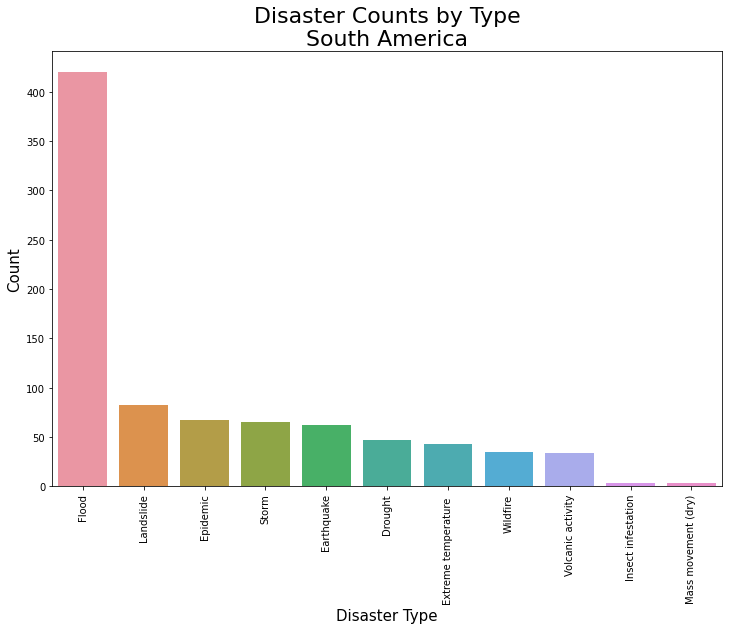

In [38]:
bar_plot_region('South America', 'Disaster Type', 'Count', 'Disaster Counts by Type\nSouth America', rotate=90)

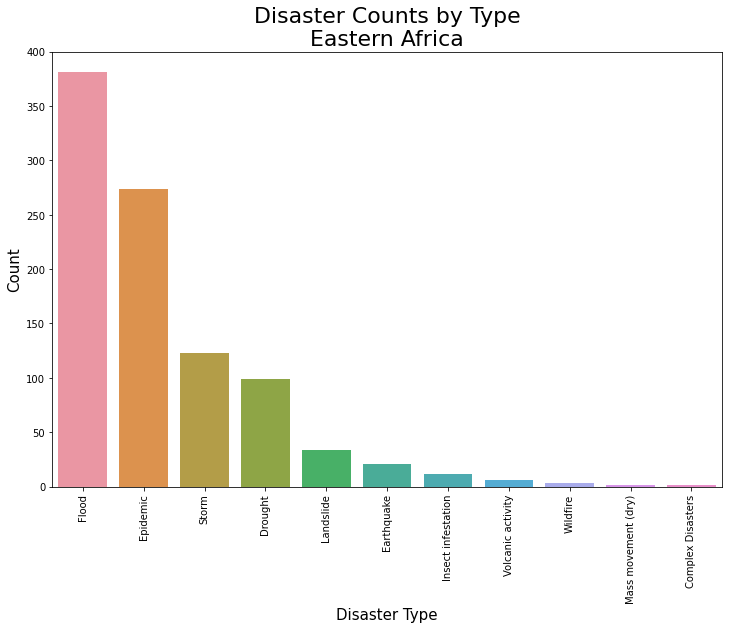

In [39]:
bar_plot_region('Eastern Africa', 'Disaster Type', 'Count', 'Disaster Counts by Type\nEastern Africa', rotate=90)

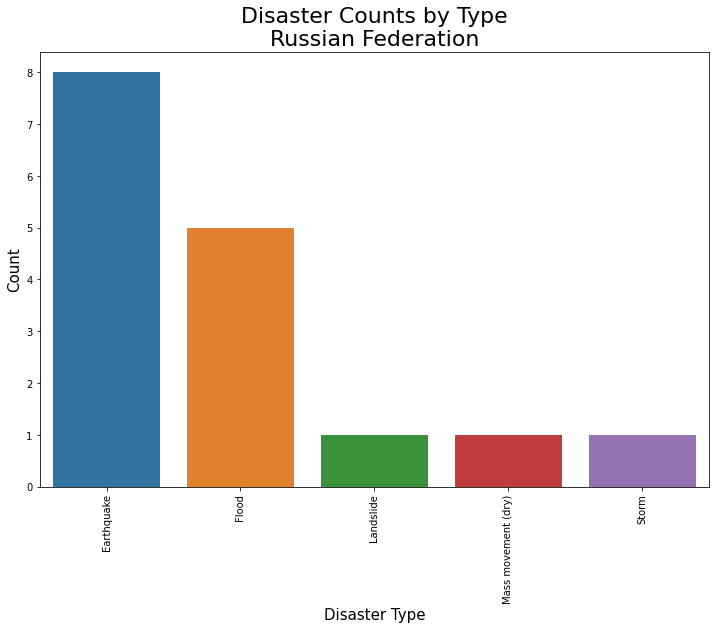

In [40]:
bar_plot_region('Russian Federation', 'Disaster Type', 'Count', 'Disaster Counts by Type\nRussian Federation', rotate=90)

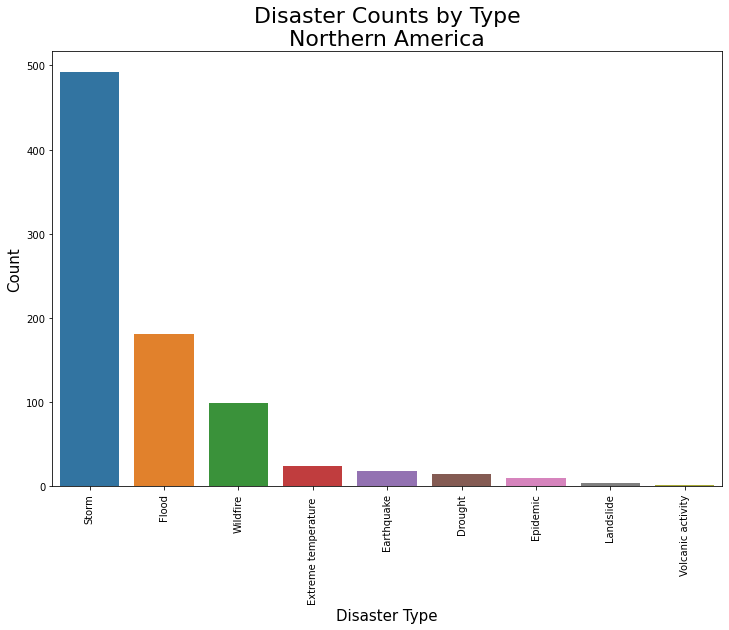

In [41]:
bar_plot_region('Northern America', 'Disaster Type', 'Count', 'Disaster Counts by Type\nNorthern America', rotate=90)

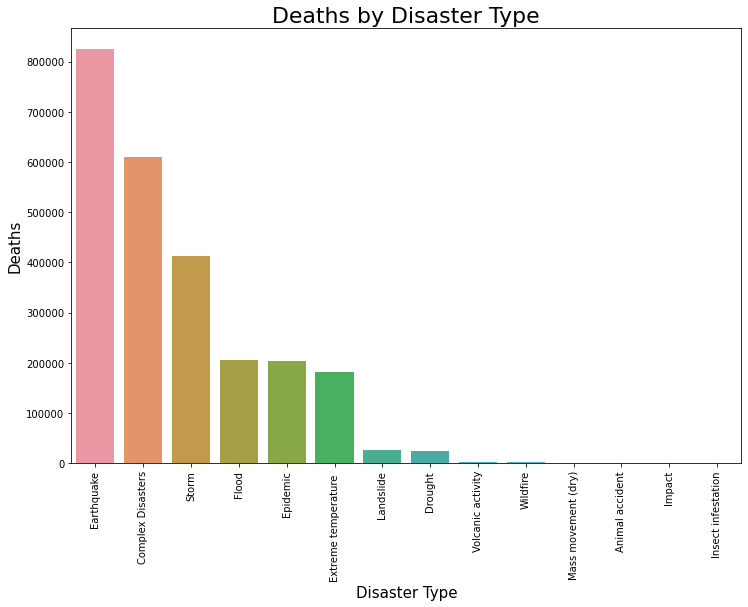

In [42]:
death_df = disaster_df_full[['disaster_type', 'deaths']].groupby('disaster_type').sum().sort_values('deaths', ascending=False)
plt.figure(figsize=(12,8))
ax = sns.barplot(x=death_df.index, y=death_df.deaths)
ax.set_xlabel('Disaster Type', fontsize=15)
ax.set_ylabel('Deaths', fontsize=15)
ax.set_title('Deaths by Disaster Type', fontsize=22)
plt.xticks(rotation=90)
plt.show()

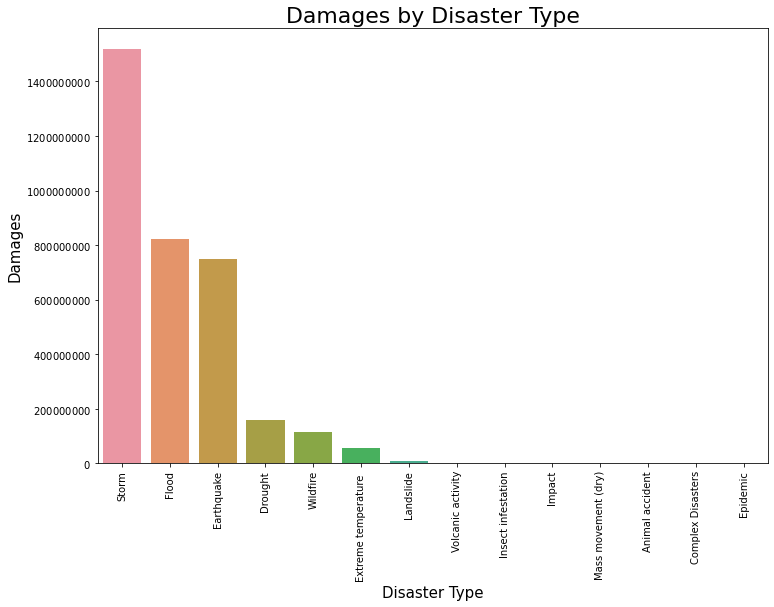

In [43]:
damages_df = disaster_df_full[['disaster_type', 'damages']].groupby('disaster_type').sum().sort_values('damages', ascending=False)
plt.figure(figsize=(12,8))
ax = sns.barplot(x=damages_df.index, y=damages_df.damages)
ax.set_xlabel('Disaster Type', fontsize=15)
ax.set_ylabel('Damages', fontsize=15)
ax.set_title('Damages by Disaster Type', fontsize=22)
ax.ticklabel_format(style='plain', axis='y', useMathText=True)
plt.xticks(rotation=90)
plt.show()

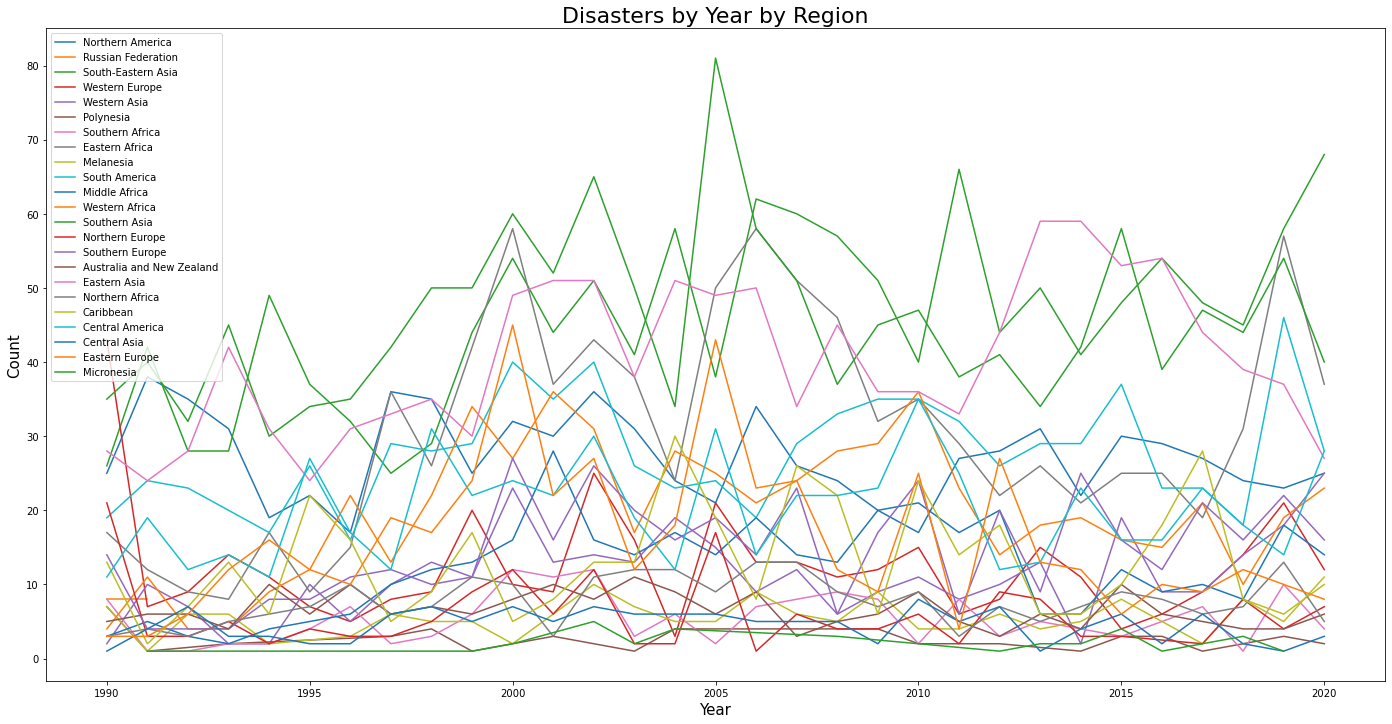

In [44]:
plt.figure(figsize=(24,12))
ax = sns.lineplot()
ax.set_xlabel('Year', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title('Disasters by Year by Region', fontsize=22)
# sns.palplot(sns.color_palette('Set1', 23))

for reg in (disaster_df_full.region.unique()):
    reg_df = disaster_df_full[disaster_df_full.region == reg].year.value_counts().sort_index()
    ax.plot(reg_df.index, reg_df.values, label=reg)

ax.legend()
plt.show()

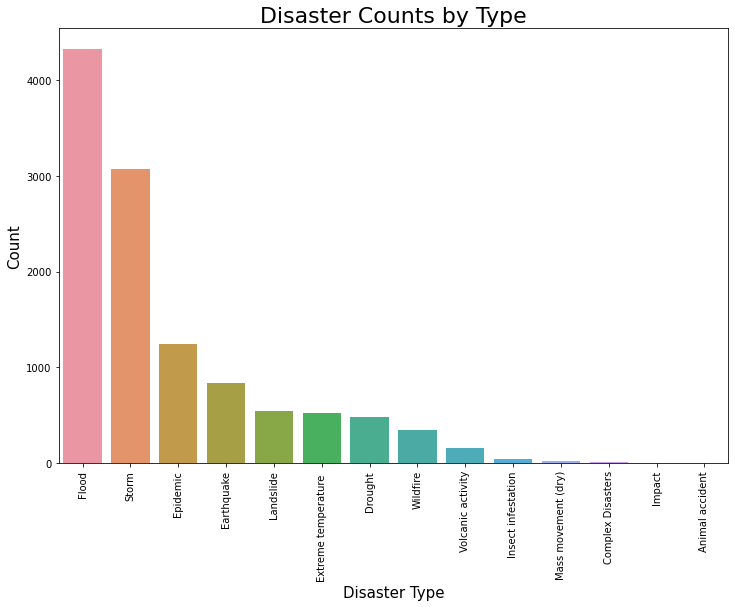

In [45]:
bar_plot(disaster_df_full['disaster_type'], 'Disaster Type', 'Count', 'Disaster Counts by Type', rotate=90)

In [46]:
disaster_df_full[['year','region','damages']].groupby(['year','region']).sum().sort_values(['year','damages'], ascending=False).head(21)

damages
year region                               
2020 Northern America           79100000.0
     Southern Asia              32388000.0
     Eastern Asia               30713700.0
     Southern Europe             8503000.0
     Central America             6946000.0
     Australia and New Zealand   4010000.0
     South America               3820000.0
     South-Eastern Asia          2781566.0
     Western Asia                1523000.0
     Caribbean                   1174800.0
     Western Europe              1053000.0
     Eastern Europe               400861.0
     Northern Africa              326000.0
     Northern Europe              130000.0
     Western Africa               128000.0
     Polynesia                    111000.0
     Melanesia                     14120.0
     Eastern Africa                10000.0
     Central Asia                      0.0
     Middle Africa                     0.0
     Southern Africa                   0.0

In [47]:
disaster_df_full[['year','region','deaths']].groupby(['year','region']).sum().sort_values(['year','deaths'], ascending=False).head(21)

deaths
year region                           
2020 Southern Asia              4067.0
     Western Europe             3812.0
     Northern Europe            2569.0
     South-Eastern Asia          983.0
     Eastern Asia                661.0
     Eastern Africa              634.0
     Central America             570.0
     Western Africa              472.0
     Western Asia                325.0
     South America               310.0
     Northern America            254.0
     Northern Africa             201.0
     Middle Africa               194.0
     Melanesia                    83.0
     Caribbean                    56.0
     Southern Europe              56.0
     Eastern Europe               27.0
     Southern Africa              13.0
     Central Asia                  6.0
     Australia and New Zealand     1.0
     Polynesia                     0.0

In [48]:
disaster_df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11623 entries, 0 to 11622
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           11623 non-null  int64  
 1   country_code   11623 non-null  object 
 2   region         11623 non-null  object 
 3   disaster_type  11623 non-null  object 
 4   deaths         8246 non-null   float64
 5   damages        3905 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 545.0+ KB


In [49]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    31 non-null     int64  
 1   tmin    31 non-null     float64
 2   tmax    31 non-null     float64
 3   tavg    31 non-null     float64
 4   prcp    31 non-null     float64
 5   snow    31 non-null     float64
 6   snwd    31 non-null     float64
dtypes: float64(6), int64(1)
memory usage: 1.8 KB


In [50]:
disaster_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   year     31 non-null     int64
 1   count    31 non-null     int64
 2   deaths   31 non-null     int64
 3   damages  31 non-null     int64
dtypes: int64(4)
memory usage: 1.1 KB


In [51]:
# disaster_df = disaster_df[(disaster_df.year >= 1990) & (disaster_df.year < 2021)]

<AxesSubplot:>

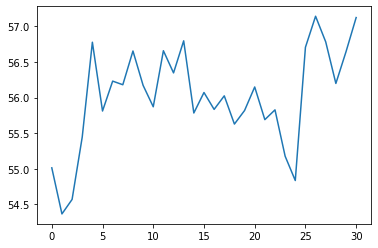

In [52]:
weather_df.tavg.plot()

<AxesSubplot:>

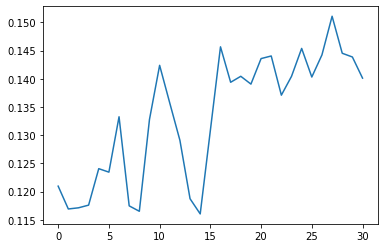

In [53]:
weather_df.prcp.plot()

<AxesSubplot:>

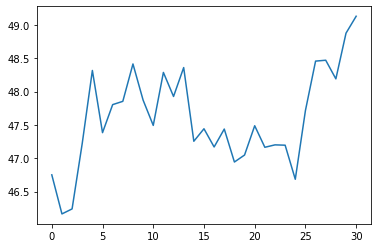

In [54]:
weather_df.tmin.plot()

<AxesSubplot:>

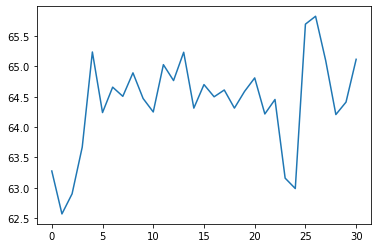

In [55]:
weather_df.tmax.plot()

<AxesSubplot:>

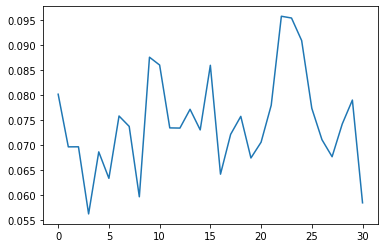

In [56]:
weather_df.snow.plot()

<AxesSubplot:>

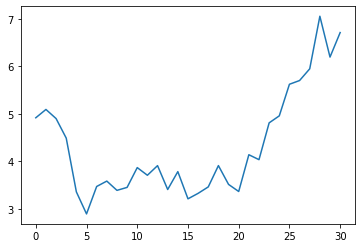

In [57]:
weather_df.snwd.plot()

In [58]:
disaster_df.deaths.mean()

80520.3870967742

In [59]:
disaster_df.damages.mean()

110614877.74193548

In [60]:
# disaster_df_year = disaster_df.year.value_counts(sort=False)
# disaster_df_year

<AxesSubplot:>

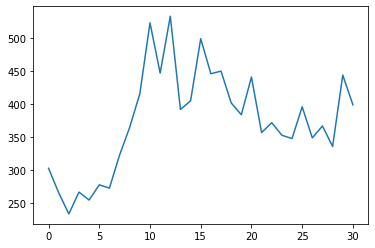

In [61]:
disaster_df['count'].plot()

<AxesSubplot:>

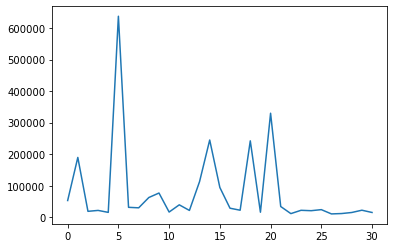

In [62]:
disaster_df.deaths.plot()

<AxesSubplot:>

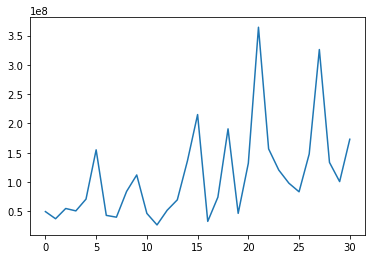

In [63]:
disaster_df.damages.plot()

In [64]:
combined = pd.merge(weather_df, disaster_df, on='year')
combined

,year,tmin,tmax,tavg,prcp,snow,snwd,count,deaths,damages
0,1990,46.751136,63.276276,55.013706,0.120957,0.080108,4.917624,303,53133,49779822
1,1991,46.165117,62.568618,54.366868,0.116913,0.069574,5.092871,266,189707,37593461
2,1992,46.240191,62.899981,54.570086,0.117116,0.069587,4.900861,234,18913,55098163
3,1993,47.222572,63.669614,55.446093,0.117592,0.056154,4.489111,267,21821,50992889
4,1994,48.316513,65.238231,56.777372,0.124054,0.068569,3.356423,255,15590,71033574
5,1995,47.383787,64.239496,55.811641,0.123440,0.063278,2.892808,278,637166,155071039
6,1996,47.804272,64.658503,56.231388,0.133255,0.075748,3.470398,273,31595,43327243
7,1997,47.853521,64.507270,56.180395,0.117464,0.073669,3.584055,323,30024,40261946
8,1998,48.414172,64.894335,56.654253,0.116503,0.059583,3.388906,365,62673,84132740
9,1999,47.872045,64.471927,56.171986,0.132776,0.087518,3.451413,416,76906,112248954


In [66]:
combined.corr()

,year,tmin,tmax,tavg,prcp,snow,snwd,count,deaths,damages
year,1.000000,0.411001,0.359349,0.409465,0.801632,0.207489,0.555087,0.395345,-0.232393,0.507910
tmin,0.411001,1.000000,0.759631,0.932624,0.227014,-0.228293,0.255031,0.277451,-0.207237,0.142533
tmax,0.359349,0.759631,1.000000,0.943130,0.266906,-0.231063,-0.086782,0.388758,-0.084760,0.171654
tavg,0.409465,0.932624,0.943130,1.000000,0.264129,-0.244896,0.082206,0.357520,-0.152957,0.168097
prcp,0.801632,0.227014,0.266906,0.264129,1.000000,0.273229,0.356368,0.430459,-0.246406,0.419149
snow,0.207489,-0.228293,-0.231063,-0.244896,0.273229,1.000000,-0.026721,0.257441,-0.198115,0.101983
snwd,0.555087,0.255031,-0.086782,0.082206,0.356368,-0.026721,1.000000,-0.153971,-0.360437,0.217768
count,0.395345,0.277451,0.388758,0.357520,0.430459,0.257441,-0.153971,1.000000,-0.110166,0.069684
deaths,-0.232393,-0.207237,-0.084760,-0.152957,-0.246406,-0.198115,-0.360437,-0.110166,1.000000,0.137322
damages,0.507910,0.142533,0.171654,0.168097,0.419149,0.101983,0.217768,0.069684,0.137322,1.000000
